In [8]:
import sys

import librosa
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import keras.layers as kl
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, Activation, Input, Concatenate
from tensorflow.keras.models import Model


path = 'C:/Users/ian03/Desktop/MLproject/Latest/AudioNNRep/functions'
sys.path.append('C:/Users/ian03/Desktop/MLproject/Latest/AudioNNRep/functions')

import functions as f

inst_path = "C:/Users/ian03/Desktop/MLproject/AudioNNRepository/audio/"


In [9]:
#Initialize the list of instruments
filenames = f.read_files_in_dir(inst_path)
#pianos = [filename for filename in filenames if "piano" in filename] #empty
bass = [filename for filename in filenames if "bass" in filename]
guitar = [filename for filename in filenames if "guitar" in filename]
#drum = [filename for filename in filenames if "drum" in filename] #empty
flutes = [filename for filename in filenames if "flute" in filename]
keyboards = [filename for filename in filenames if "keyboard" in filename] 


instrument_list = [bass, guitar, flutes, keyboards]

In [10]:
#Generate data
data, labels, original_labels = f.nu_gen_spectro(5000, instrument_list, path = inst_path, target_shape=(1025, 126))


In [4]:
#define the model

kernelsize = (3, 126)
target_shape = (1025, 126)

class AudioDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]


class UNet(nn.Module):
    def __init__(self,input_channels = 1,output_channels = 4):
        super(UNet, self).__init__()
        # Define the contracting/downsampling path
        # Changed stride to (1, 1) and adjusted padding to maintain height and width
        self.conv1 = nn.Conv2d(input_channels, 16, kernel_size = kernelsize, stride=1, padding=(1, 0))
        self.conv2 = nn.Conv2d(16, 32, 3, stride=1, padding=1)
        # Define the expanding/upsampling path
        self.upconv1 = nn.ConvTranspose2d(32, 16, 2, stride=2)
        self.conv3 = nn.Conv2d(32, 16, 3, padding=1)
        self.upconv2 = nn.ConvTranspose2d(16, 8, 2, stride=2)
        self.conv4 = nn.Conv2d(24, 8, 3, padding=1)
        self.conv5 = nn.Conv2d(8, output_channels, 3, padding=1)

    def forward(self, x):
        # Contracting path
        x1 = F.relu(self.conv1(x))
        x2 = F.relu(self.conv2(x1))
        
        # Expanding path with skip connections
        x = self.upconv1(x2)
        x = F.interpolate(x, size=(x1.size(2), x1.size(3)), mode='bilinear', align_corners=True)
        x = torch.cat([x, x1], dim=1)
        x = F.relu(self.conv3(x))
        
        x = self.upconv2(x)
        x = F.interpolate(x, size=(x1.size(2), x1.size(3)), mode='bilinear', align_corners=True)
        x = torch.cat([x, x1], dim=1)
        x = F.relu(self.conv4(x))
        
        # Apply the final convolution layer
        x = self.conv5(x)
        
        # Resize x to the desired size
        x = F.interpolate(x, size=target_shape, mode='bilinear', align_corners=True)
        #print(f"output shape: {x.shape}")
        return x
# Split the data into training and testing sets
#data = data[..., np.newaxis]
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)
print(y_train.shape)
X_train = np.expand_dims(X_train, axis=1)
X_test = np.expand_dims(X_test, axis=1)
print(X_train.shape)
# Create the datasets and dataloaders
train_dataset = AudioDataset(X_train, y_train)
test_dataset = AudioDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
#print(train_dataset[0][0].shape)

# Get a batch of data
inputs, targets = next(iter(train_loader))

# Print the shape of the inputs
print(inputs.shape)

(400, 4, 1025, 126)
(400, 1, 1025, 126)
torch.Size([32, 1, 1025, 126])


In [5]:
# Initialize the model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_channels = X_train.shape[1]  # Get the number of input channels from the data
model = UNet(input_channels=input_channels,output_channels=4).to(device, dtype=torch.float32)


In [13]:
print(len(y_train[1]))

4


In [17]:

#print(model)
class AbsoluteLogDifferenceLoss(nn.Module):
    def __init__(self):
        super(AbsoluteLogDifferenceLoss, self).__init__()

    def forward(self, y_pred, y_true):
        # Ensure that we avoid log of zero by adding a small epsilon
        epsilon = 1e-6
        # if y_pred is negative set it to 0
        y_pred = torch.clamp(y_pred, min=0)
        # if y_pred is infite set it to 0
        log_diffs = 0
        for i in range(len(y_pred[1])):
            log_diffs += torch.mean(torch.abs(torch.log(y_pred[:,i,:] + epsilon) - torch.log(y_true[:,i,:] + epsilon)))
        
        #print(log_diff)
        #regulator = 1
        #penalty = torch.abs(torch.log(y_pred[:,0,:])) + torch.abs(torch.log(y_pred[:,1,:])) - (torch.abs(torch.log(y_true[:,0,:])) + torch.abs(torch.log(y_true[:,1,:])))
        #penalty = torch.abs(y_pred[:,2,:])
        #print(penalty)
        #+ LA.matrix_norm(regulator*penalty, ord = 'fro')
        # Use the L2 norm to calulate the loss
        loss = log_diffs #+ torch.mean(regulator*penalty)
        #print(np.shape(loss))
        return loss


criterion = AbsoluteLogDifferenceLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for X, y in train_loader:
        X, y = X.to(device, dtype=torch.float32), y.to(device, dtype=torch.float32)

        #print(f"Shape of x : {X.shape},Shape of y {y.shape}")
        optimizer.zero_grad()
        y_pred = model(X)
        #loss = criterion(y_pred, y)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X.size(0)  # Accumulate loss
    
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch {epoch + 1}, Loss: {epoch_loss:.4f}')

# Evaluate the model
model.eval()
losses = []
weights = []
with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device, dtype=torch.float32), y.to(device, dtype=torch.float32)
        y_pred = model(X)
        loss = criterion(y_pred, y)
        losses.append(loss.item() * X.size(0))
        weights.append(X.size(0))

    

average_loss = sum(losses) / len(test_loader.dataset)
print(f'Average Loss: {average_loss:.4f}')
torch.save(model.state_dict(), 'your_model_weights.pth')

Epoch 1, Loss: 4.6693
Epoch 2, Loss: 4.6692
Epoch 3, Loss: 4.6692
Epoch 4, Loss: 4.6692
Epoch 5, Loss: 4.6692
Epoch 6, Loss: 4.6692
Epoch 7, Loss: 4.6692
Epoch 8, Loss: 4.6692
Epoch 9, Loss: 4.6692
Epoch 10, Loss: 4.6692
Average Loss: 4.4913


[array([3.0517578e-05, 1.5258789e-04, 3.3569336e-04, ..., 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00], dtype=float32), array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)]


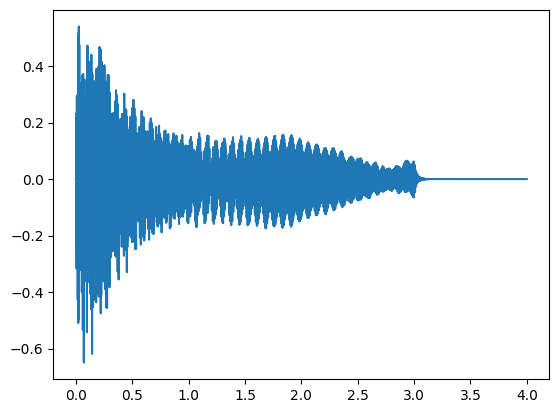

In [18]:
#Generate a random waveform
import matplotlib.pyplot as plt
import soundfile as sf
#Pick a random sample of each instrument
filepaths, labels = f.pick_samples_and_classify(instrument_list)

#Extract .wav data into to a list
waveforms = f.add_waveform_to_list(filepaths, path = inst_path)

#Combine the waveforms
combined_waveform = f.combine_waveforms(waveforms)

print(waveforms)
#Save the combined waveform to a wav file using librosa
sf.write('combined_waveform.wav', combined_waveform, 16000)

frame_rate = 16000
time = np.linspace(0, len(combined_waveform)/frame_rate, num=len(combined_waveform))

plt.figure()
plt.plot(time, combined_waveform)


In [35]:
filepaths

[array(['bass_synthetic_009-047-127.wav'], dtype='<U31')]

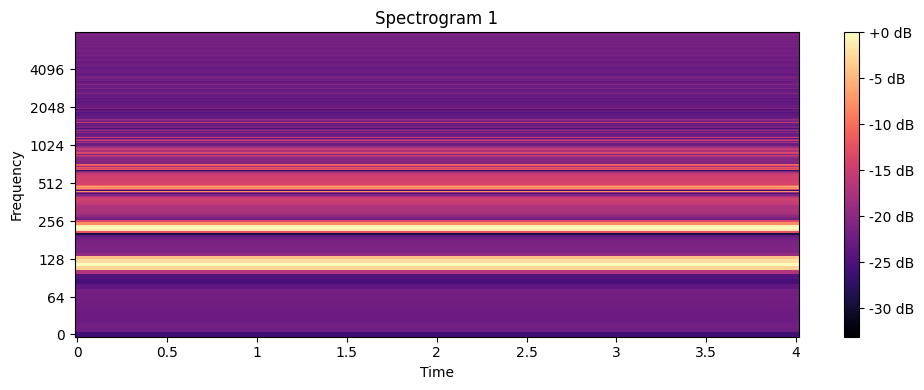

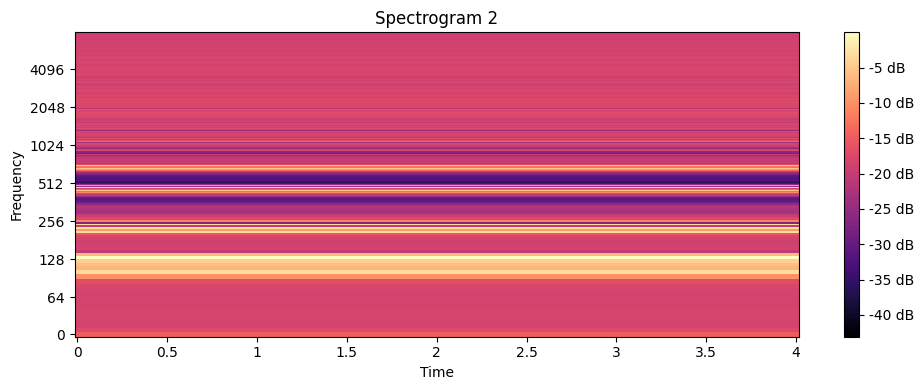

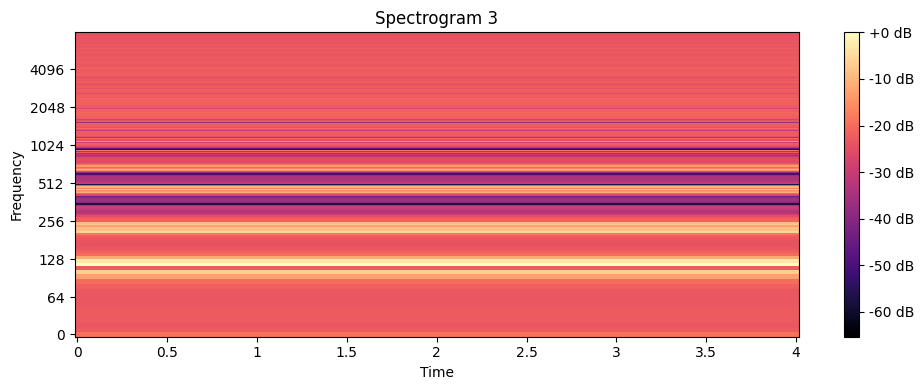

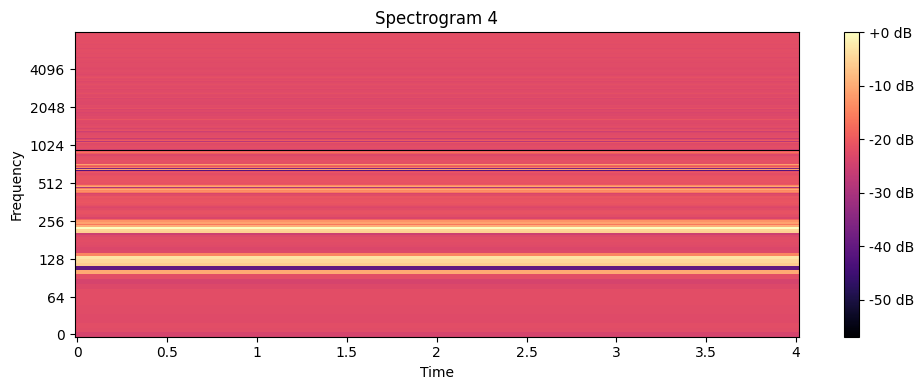

In [19]:
import wave
import matplotlib.pyplot as plt

with wave.open("combined_waveform.wav", "rb") as wave_file:
    input_audio = wave_file.readframes(-1)
    input_sr = wave_file.getframerate()

combined_waveform, input_sr = librosa.load("combined_waveform.wav", sr = None)

spectrogam = f.waveform_to_spectogram(combined_waveform)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(input_channels=input_channels,output_channels=4).to(device, dtype=torch.float32)
model.load_state_dict(torch.load('your_model_weights.pth'))
model.eval()

input_tensor = torch.tensor(spectrogam, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device, dtype=torch.float32)

with torch.no_grad():
    output_tensor = model(input_tensor)

def plot_seperated_spectrogram(output_tensor, sr):
    for i, spec in enumerate(output_tensor):
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(librosa.amplitude_to_db(spec, ref=np.max), sr=sr, x_axis='time', y_axis='log')
        plt.colorbar(format='%+2.0f dB')
        plt.title(f'Spectrogram {i + 1}')
        plt.xlabel('Time')
        plt.ylabel('Frequency')
        plt.tight_layout()
        plt.show()


output_tensor = output_tensor.squeeze().cpu().numpy()
plot_seperated_spectrogram(output_tensor, input_sr)

In [20]:
import os
output_folder = "output_audio"
os.makedirs(output_folder, exist_ok=True)   
for i, source in enumerate(output_tensor):
    output_filepath = os.path.join(output_folder, f"output_{i}.wav")
    f.spectrogram_to_audio(source, input_sr, output_filepath)

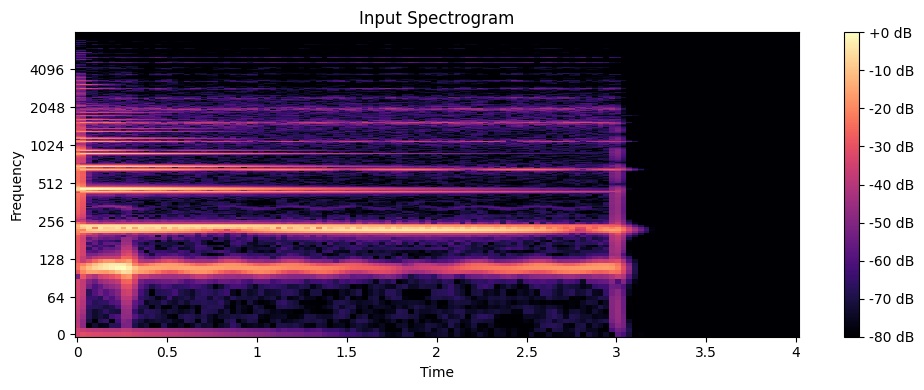

In [21]:
#Plot the input spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.amplitude_to_db(spectrogam, ref=np.max), sr=input_sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Input Spectrogram')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()
